<a href="https://colab.research.google.com/github/berrehalbadr/Applied-Data-Science-Course-in-the-Oil-and-Gas-Industry/blob/main/Course%20Notebooks/04-%20Data%20through%20a%20statistician%20eyes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>

# Applied Data Science in the Oil and Gas Industry 
## Tutorial 4: Data through a statistician eyes

---
### Badr Eddine Berrehal (Petroleum Engineer & Data Detective)
- **Email:** [berrehalbadr@gmail.com](berrehalbadr@gmail.com)
- **LinkedIn:** [Badr Berrehal](https://www.linkedin.com/in/badreddine-berrehal-a51010175)
- **Personal Web site:** [UDATA](https://sites.google.com/view/badreddine-berrehal/accueil)
- **GitHub:** [berrehalbadr](https://github.com/berrehalbadr)
- **License Type:** MIT license
---

# Notebook Content
- **What's this about**
- **Investigating the data (Exploratory Data Analysis)**
    - Looking for central tendency
    - Examining data variability
    - Investigating parameters distribution
    - Investigating data correlations
- **Representative selection and data distributions**
    - Sampling and introduction to key concepts
    - A guide to data distributions

# 1. What's this about
In the previous notebook `03 - Dealing with data`, we learned how to process data in different formats, how to convert it into a Pandas `DataFrame` for easier manipulation, and then we went through a series of the most common wrangling and cleaning techniques typical of any data analysis or machine learning project, using production data from Equinor's Volve field.
In this notebook, we will try to understand what the data might tell us using statistical tools. In my own experience, when interpreting data, most people, including myself, introduce some kind of bias, which is very typical, especially when you can manipulate the data yourself to fit your perspective on the process, this is exactly why I referred to the "Handling the data" workbook as "80% of your work", from there it all builds up, so if your initial manipulation is not **fair** to some degree, it will ruin your whole analysis, let alone machine learning models.

Statistics, when understood properly, can help navigate projects without potentially including a subjective view. So in this notebook, we'll explore the most essential concepts of this crucial discipline and see how to practically implement them using python on real data.

In [2]:
# Let's import the libs we need
import pandas as pd
import numpy as np
from scipy.stats import trim_mean
import wquantiles
from statsmodels import robust
from sklearn.utils import resample
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
import lasio

from matplotlib import colors
from matplotlib.collections import EllipseCollection
from matplotlib.colors import Normalize
import warnings
warnings.filterwarnings("ignore")

___

# 2. Investigating the data 
Exploratory data analysis, or EDA for short, is the initial stage of a project, along with cleaning and organizing. Through this process, we typically examine the relationship between different metrics. but before we proceed, let's establish some common terminology with respect to keywords. Indeed, because data science is so versatile, many disciplines contribute to it, so some keywords can be used interchangeably. 

- **Data frame**: Rectangular data (like a spreadsheet) is the basic data structure for statistical and machine learning models.
- **Feature** (attribute, input, predictor, variable): a parameter describes a measure, generally a column within a table.
- **Outcome** (dependent variable, response, target, output): in ML linguo, a parameter of intrest, generally set to be predicted using some sort of algorithm.
- **Records** (case, example, instance, observation, pattern, sample): A single measure in the table or row.

## 2.1 Looking for central tendency
So, depending on the project you are working on, the data can include a few features and a few dozen records, to hundreds of parameters and thousands or even millions of records (seriously, I am not kidding). So, to get off to a good start, it's usually a good idea to look for what are called **Location Estimates**, which show the general trend of the data being examined, and specifically the **center** of it.

There are plenty of these so-called estimates, and their use generally depends on the cleaness of the data itself. What I mean by that is that you generally opt for more robust approaches when you suspect that there are potential outliers. Let's examine this through some examples.

Let's take a look at some drilling bit data, and assess it slighly.

We'll  use the [Kaggle's oil spills data set](https://www.kaggle.com/datasets/usdot/pipeline-accidents?datasetId=801&sortBy=voteCount) the data is already provided in the data folder as `oil_spills` but I encourage you to check it out.

In [3]:
# read csv file into pandas DataFrame
df = pd.read_csv("Data/drilling_bit_data.csv")

In [4]:
df.head()

,Size,Manufacturer,Type,Footage,Blades,Cutter size,WOB,ROP,Mud Weight,RPM,Torque
0,36.0,A,Tricone,82,3,0,13.0,10.10,8.5,80,5.0
1,26.0,A,Tricone,709,3,0,78.0,11.29,8.5,73,11.0
2,26.0,A,Tricone,547,3,0,78.0,11.29,8.5,73,11.0
3,26.0,A,Tricone,438,3,0,55.0,14.32,9.6,168,13.0
4,26.0,C,Tricone,320,3,0,55.0,14.32,9.6,168,13.0


**A quick description:**
- Size : Drilling bit front radius in inches
- Manufacturer : The company which the bit belongs to
- Type : Bit's model 
- Footage : Distance drilled into the formation in feet
- Blades : Number of drill components
- Cutter size : Specific to the cut based models
- WOB : Average applied weight on the bit
- ROP : Average rate of penetration
- Mud weight : Used drilling fluid weight for hydrostatique pressure
- Torque : The resistance to rotation due to friction

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204 entries, 0 to 203
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Size          204 non-null    float64
 1   Manufacturer  204 non-null    object 
 2   Type          204 non-null    object 
 3   Footage       204 non-null    int64  
 4   Blades        204 non-null    int64  
 5   Cutter size   204 non-null    int64  
 6   WOB           204 non-null    float64
 7   ROP           204 non-null    float64
 8   Mud Weight    204 non-null    float64
 9   RPM           204 non-null    int64  
 10  Torque        204 non-null    float64
dtypes: float64(5), int64(4), object(2)
memory usage: 17.7+ KB


Let's strat with the **Mean** also known as the **Average**. which is defined as the sum of all values divided by the number of values.

In [6]:
# The average ROP or rate of penetration for these bits
df.ROP.mean()

12.134313725490204

Okey, so the average rate of penetration for this dataset collection is *12* ft/hr, this is pretty weird, but wait are we making justice to this set? let's first look up the `Type` column.

In [7]:
df.Type.value_counts()

PDC            174
Tricone         22
Hybrid           4
Impregnated      4
Name: Type, dtype: int64

Oh well look at that, there are more than a single class. Although our assessment for the avarage ROP for the entity of the data isn't false, it doesn't do justice to the class ain't? What would happen if we devided the classes.

In [8]:
for bit in df.Type.unique():
    print("The average ROP for {} in this data is: {}".format(bit ,df.loc[df.Type==bit]['ROP'].mean()))

The average ROP for Tricone in this data is: 8.323181818181816
The average ROP for PDC in this data is: 12.88011494252874
The average ROP for Impregnated in this data is: 2.6125
The average ROP for Hybrid in this data is: 10.175


Okay, that's a little more insightful. But what if I told you that the bits were not used in one region, and the dimensions of the bit affect the overall ROP, and they were not used equally, some are new and some are half dull, and what if I told you that they were not made by the same manufacturer...

Does this affect your perspective a **bit** (*drilling joke lol*)? The message that I want deliver accross, is that the question you seek to answer has to be very precise, in order to get a modestly satisfying answer.

All right, now I want to show you some variations of the mean. The first is the **Trimmed Average**, by definition this is the average of all the values after **removing** a fixed number of extreme values.

Let's say you suspect your data has extreme outliers, the trimmed option allows you to get rid of a percentage at both extremes, to reduce its effect on the calculated metric, to compute we use [scipy](https://scipy.org/) `trim_mean` method.

I suspect that some values especially for the PDC type are affecting the mean, so let's trim 10% of each extreem, what do you think will happen to the mean ?

For clarity let's take only the PDCs and put them in a new DataFrame that we'll call `df_pdc`.

In [9]:
df_pdc = df.loc[df.Type=="PDC"]

In [10]:
print('The mean with 10% off is : {}'.format(trim_mean(df_pdc['ROP'], 0.10)))
print('The delta with 10% off is {}'.format(float(df_pdc['ROP'].mean()) - float(trim_mean(df_pdc['ROP'], 0.10))))

The mean with 10% off is : 10.190142857142856
The delta with 10% off is 2.689972085385884


Hmmm intresting, so we reduced 10% of each extreem and the mean value droped by 2.7. This probably means that there is a relative tendency to higher values in ROP. Keep changing the `trim` value and see what happens. 

Okay, another variant of the average is called the **Weighted Average**, by definition it is the sum of all values times a weight divided by the sum of the weights, there is one main application for this one, when you want to assign a different degree of **importance** to each observation, say maybe the data doesn't reflect the existing classes well, or if you suspect that a specific record is untrustworthy (e.g. a defective sensor).

In our example, I want to look up two specifically, the `ROP` weighted against the `Footage` and the number of `Blades`.

In [11]:
print('The mean for Footage-weighted ROP is : {}'.format(np.average(df_pdc['ROP'], weights=df_pdc['Footage'])))
print('The mean for Blade number-weighted ROP is : {}'.format(np.average(df_pdc['ROP'], weights=df_pdc['Blades'])))

The mean for Footage-weighted ROP is : 23.049242253188876
The mean for Blade number-weighted ROP is : 13.435082095387022


:D wait a minute, what's going on here, hh? values have increased! What does that *mean*? 

Well, since **Weighted by value** means multiplying each observation of the parameter under study by its respective **weight** value and dividing the entity of it by the sum of the **weights**. This might indicate that the `Footage` or distance traveled has a greater effect on the `ROP` than the number of `Blades`, and that a shorter `Footage` tends to have a higher `ROP` which makes sense to some extent, you can't keep a very high rate indefinitely.

I hope this has provided you with a some insight into how to approach an analysis, no matter how simple it may be. Now let's move on to another key metric, the **Median**.
By definition it's the value such that one-half of the data lies above and below (the mid-point), the latter is generaly used as well since it's Unsensitive to outlier values.
To compute it we just have to use Pandas.

In [12]:
print("The median ROP value is: {}".format(df['ROP'].median()))

The median ROP value is: 7.35


Hmmm alright, so the mid-point within the whole data is *7.35*, would it change if we seperate the type? of course.

In [13]:
for bit in df.Type.unique():
    print("The mid ROP value for {} in this data is: {}".format(bit ,df.loc[df.Type==bit]['ROP'].median()))

The mid ROP value for Tricone in this data is: 8.3
The mid ROP value for PDC in this data is: 7.2
The mid ROP value for Impregnated in this data is: 2.645
The mid ROP value for Hybrid in this data is: 10.9


Just like the Mean, the median is has also a variant being the **Weighted Median**, the latter is defined as The value such that one-half of the sum of the weights lies above and below the sorted data, and can be computed using [wquantiles](https://pypi.org/project/wquantiles/) special package.

In [14]:
# Let's see the Footage weighted ROP for the entire data
print(wquantiles.median(df['ROP'], weights=df['Footage']))

15.9


**Note**
- Metrics or models which are unsensitive to extreme values are commonly referred as **Robust**.
- There is a plathora of central measures, which can be caluclated easily using the python's most known statistical module [statistics](https://docs.python.org/3/library/statistics.html), including the Geometric and Harmonic Mean, the Mode, etc. Each with a specific utility, for further reading on the topic reffer to the main page.

## 2.2 Examining data variability
In addition to central tendencies, **variability**, also known as **dispersion**, plays an essential role in statistics. It quantifies the **spread** of a parameter, i.e. whether data points are closely grouped around a central value or whether they are scattred over a wide range. 

Starting with the **Deviation** (erros, residual) which is the difference between the observed values and the estimate of location. It's simply computed by subtracting the mean of each individual observation.

A typical way tp measure variability is to estimate some value of these deviations. For example the **Mean Absolute Deviation**, which is the sum of absolute deviation from the central metric devided by the the number of observation. Why *Absolute* tho? simply because the sum of deviation from the mean equals 0, since negative values cancel negative values.

But the most commonly used metrics of variability include **Variance** also known as the **Mean Squared Error**, which is The sum of squared deviations from the mean divided by n – 1 where *n* is the number of data values.
And the **Standard Deviation** defined as the square root of the Variance.

The reason why **Var** and **SD** are considered the best is related to mathematical theory, because it is more convenient to work with squared values than with absolute ones.

Here's how to calculate them.

In [15]:
# standard deviation of ROP
print("The Standard Deviation for ROP is: {}".format(df['ROP'].std()))
print("The Variance of the ROP is: {}".format((df['ROP'].std())**2))

The Standard Deviation for ROP is: 12.484368986249786
The Variance of the ROP is: 155.8594689848355


So how to interpret this? What is this value saying? Well we said that it measures spread or (compactness) of data, but how can we distinguish if it high or low? A common method is calculating it's ratio to the Mean also known as the **Variance Coefficient** or **SD/Mean**.

if **VC< 1**: this means the spread is low, and measures are quite centred around the Mean value.
if **VC> 1**: this means the spread is high, and measures are do not revolve around the central tendency.

Let's create a function for VC.

**Note:**
When the **SD** is equal to 0, this means that all the measures are the same.

In [16]:
df.columns

Index(['Size', 'Manufacturer', 'Type', 'Footage', 'Blades', 'Cutter size',
       'WOB', 'ROP', 'Mud Weight', 'RPM', 'Torque'],
      dtype='object')

In [17]:
cols =['Size', 'Footage', 'Blades', 
       'Cutter size', 'WOB', 'ROP','Mud Weight', 
       'RPM', 'Torque']

def VC(df):
    for col in cols:
        print("The variance coefficient for {} is: {}".format(col, round(df[str(col)].std() /df[str(col)].mean(), 2)))

In [18]:
VC(df)

The variance coefficient for Size is: 0.49
The variance coefficient for Footage is: 1.31
The variance coefficient for Blades is: 0.29
The variance coefficient for Cutter size is: 0.4
The variance coefficient for WOB is: 0.47
The variance coefficient for ROP is: 1.03
The variance coefficient for Mud Weight is: 0.14
The variance coefficient for RPM is: 0.27
The variance coefficient for Torque is: 0.28


So according to what you've seen so far, what do these values tell you on each parameter.
Later we'll see how to gain a visual perspective using a number of graphics.

It's worth mentioning that each **Var**, **SD** or **Mean-AD** is actually sensitive to outlier values. A more robust value would be **Median Absolute Deviation**, which just like the **Mean-AD** is defined as the median of the absolute values of the deviations from the median.

We can compute **MAD** using the `statsmodels` mad method.

In [19]:
# Let's compute it for ROP
print("The MAD value for ROP is: {}".format(robust.scale.mad(df['ROP'])))

The MAD value for ROP is: 6.671709983275209


And as you can guess, we can compute the ratio to the median to better interpret the result.

Another approach to make sense of statistics is reffered to as **order statistics** in which the data is ordred (sorted). The most basic measures related to the latter are data **range**, **min**, **max** and **percentiles**.

The 3 first ones are intuitive, but the last one (Percentile) also defined as quantile is defined a value such that P percent of the values take on this value or less and (100–P) percent take on this value or more. A common use of these is to caluclate the **Interquartile range** (IQR) for short, which is the difference between the 75th percentile and the 25th percentile. Let's look at an example.

In [20]:
print("The IQR for the Footage variable is: {}".format(df['Footage'].quantile(0.75) - df['Footage'].quantile(0.25)))

The IQR for the Footage variable is: 278.5


This tells us that the middle 50% of values for the `Footage` parameter has a spread of 278.5 feet.

**Note:**
- Most of these parameters can be computed at once using `Pandas` describe method, as in the follow example, but I wanted to understand what they actually reffered to.
- Just make sure when assessing these metrics, you take the right subset in respect to your question.

In [21]:
# Let's get a quick description
df.describe(include='all', percentiles=[.25, .5, .75])

,Size,Manufacturer,Type,Footage,Blades,Cutter size,WOB,ROP,Mud Weight,RPM,Torque
count,204.000000,204,204,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000
unique,NaN,4,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,D,PDC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,86,174,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,12.451593,NaN,NaN,328.200980,6.916667,13.818627,33.745098,12.134314,10.083824,136.862745,13.715000
std,6.130021,NaN,NaN,429.826559,2.026406,5.579823,15.939424,12.484369,1.402473,37.567028,3.905213
min,4.125000,NaN,NaN,0.000000,3.000000,0.000000,4.000000,0.000000,8.200000,50.000000,5.000000
25%,8.500000,NaN,NaN,74.000000,6.000000,13.000000,21.750000,4.000000,9.100000,120.000000,11.000000
50%,10.625000,NaN,NaN,183.500000,7.000000,16.000000,32.000000,7.350000,9.800000,135.500000,13.000000
75%,14.750000,NaN,NaN,352.500000,8.000000,19.000000,45.000000,15.375000,11.100000,150.000000,16.000000


## 2.3 Investigating parameters distribution
The previous metrics we calculated, allowed us to use a scale measure for location or variability, it is also very useful to study the overall distribution via a more intuitive tool, namely visuals.

In this notebook, we will only take a look at the most basic ones to get a quick idea of their usefulness, in the next notebook `05- Data visualization story telling`, we will explore the concepts of an effective visualization in more depth.

For the moment being don't bother with the code itself, we'll use python's most known visualization librery being `Matplotlib`.

Let's start with the **Boxplot**, an very intuitive for data distribution and outliers detection.

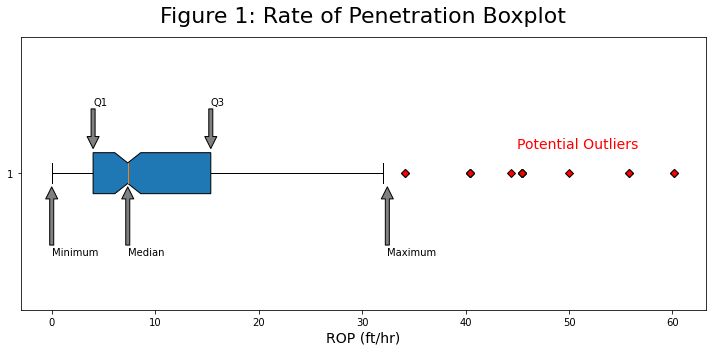

In [22]:
# Let's set some variable to annotate with
Q1=df['ROP'].quantile(0.25)
Q3=df['ROP'].quantile(0.75)
IQR= df['ROP'].quantile(0.75) - df['ROP'].quantile(0.25)
lower_end= Q1 - 1.5*IQR
higher_end= Q3 + 1.5*IQR

# Let's see the boxplot values for the ROP
fig1, ax1 = plt.subplots(figsize=(10,5))
outliers = dict(markerfacecolor='r', marker='D')

ax1.set_title('Figure 1: Rate of Penetration Boxplot', fontsize=22, fontweight='light',
              loc='Center', y=1.03)
ax1.set_xlabel('ROP (ft/hr)', fontsize=14)
ax1.boxplot(df['ROP'], vert=False, notch=True, flierprops=outliers,
            patch_artist=True )

# This is just for clarity
ax1.annotate('Median', xy=(df['ROP'].median(), .95), xytext=(df['ROP'].median(), 0.7),
             arrowprops=dict(facecolor='grey', shrink=0.001))
ax1.annotate('Minimum', xy=(0, .95), xytext=(0, 0.7),
             arrowprops=dict(facecolor='grey', shrink=0.001))
ax1.annotate('Maximum', xy=(higher_end, .95), xytext=(higher_end, 0.7),
             arrowprops=dict(facecolor='grey', shrink=0.001))
ax1.annotate('Q1', xy=(Q1, 1.09), xytext=(Q1, 1.25),
             arrowprops=dict(facecolor='grey', shrink=0.001))
ax1.annotate('Q3', xy=(Q3, 1.09), xytext=(Q3, 1.25),
             arrowprops=dict(facecolor='grey', shrink=0.001))
ax1.text(45, 1.09, 'Potential Outliers', c='r', fontsize=14)

plt.tight_layout()
plt.show()

**So what to look for?**

From this **boxplot** we can immediately see that the **median bit ROP** is about 5 ft per hour, half the **bit's ROP fall** between about 4 and about 15, and there are some high population outliers. 

The top and bottom of the box are the 75th and 25th percentiles, respectively. The median is shown by the yellow vertical line in the box. The lines out the box, referred to as **whiskers**, extend from the top and bottom of the box to indicate the range for the bulk of the data.

The **Histogram** and **Density** charts are two other very useful visual tools for examining the distribution.
- The histogram is an approximate representation of the distribution of numerical data. To construct a histogram, the first step is to "bin" (or "bucket") the range of values, that is, divide the entire range of values into a series of intervals, and then count how many values are in each interval.
- The density plot, on the other hand, is a smoothed, continuous version of a histogram estimated from the data. The peak of the density graph indicates the maximum concentration.


- One of the main advantages of the histogram is the flexibility of the number of intervals we want to study due to the number of cells. In addition, it is relatively easier to spot the so-called **statistical moments**, namely **skewness** and **kurtosis**. Skewness indicates whether the data are biased toward larger or smaller values, and kurtosis indicates the tendency of the data to have extreme values. 
- A key distinction from the histogram is the scale of the y-axis: a density plot corresponds to plotting the histogram as a proportion rather than a number. Note that the total area under the density curve is equal to 1. Instead of counting in bins, you calculate the areas under the curve between any two points on the x-axis, which correspond to the proportion of the distribution between those two points.

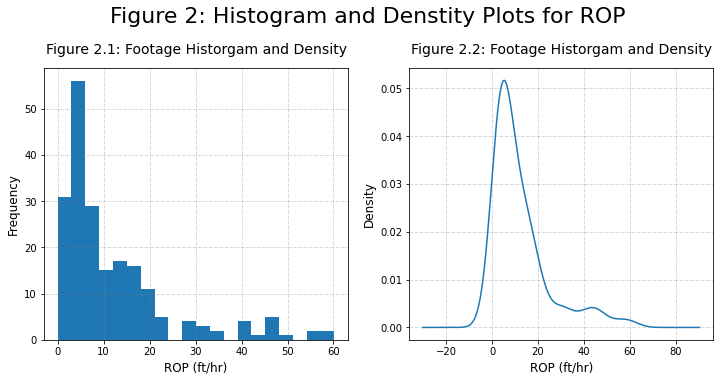

In [23]:
# Let's see the Histogram values for the Footage
fig2, axs = plt.subplots(nrows=1, ncols=2,figsize=(12,5))


# Setting axes titles
axs[0].set_title('Figure 2.1: Footage Historgam and Density', fontsize=14, fontweight='light',
              loc='Center', y=1.03)
axs[1].set_title('Figure 2.2: Footage Historgam and Density', fontsize=14, fontweight='light',
              loc='Center', y=1.03)

# Setting axes axis
axs[0].set_ylabel('Frequency', fontsize=12)
axs[1].set_ylabel('Density', fontsize=12)
axs[0].set_xlabel('ROP (ft/hr)', fontsize=12)
axs[1].set_xlabel('ROP (ft/hr)', fontsize=12)

# Plot the data
axs[0].hist(df.ROP, bins = 20)
df['ROP'].plot.density(ax=axs[1])


# Add x, y gridlines
for ax in axs:
    ax.grid(b = True, color ='grey',
            linestyle ='-.', linewidth = 0.5,
            alpha = 0.6)

# Setting figure title
plt.suptitle('Figure 2: Histogram and Denstity Plots for ROP', y=1.05, fontsize=22)
plt.show()

The two are usually combined in a single graph as in (Figure 3), let's color code the intensity for clarity.

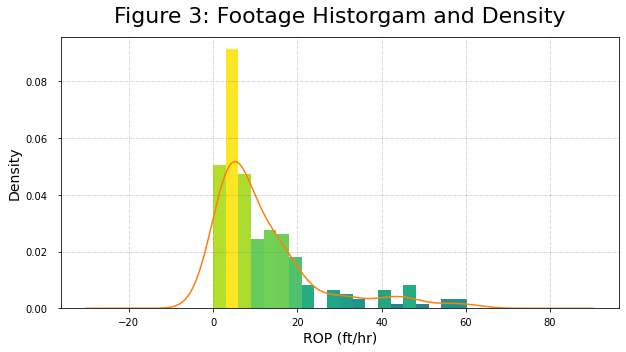

In [24]:
# Let's see the Histogram values for the Footage
fig3, ax1 = plt.subplots(figsize=(10,5))

# Setting bins and data
x= df.ROP
n_bins = 20
legend = ['Distribution']


# Creating histogram
N, bins, patches = ax1.hist(x, bins = n_bins, density=True)
df['ROP'].plot.density(ax=ax1)

# Add padding between axes and labels
ax1.xaxis.set_tick_params(pad = 5)
ax1.yaxis.set_tick_params(pad = 10)
 
# Add x, y gridlines
ax1.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.6)


# Setting color
fracs = ((N**(1 / 5)) / N.max())
norm = colors.Normalize(fracs.min(), fracs.max())
 
for thisfrac, thispatch in zip(fracs, patches):
    color = plt.cm.viridis(norm(thisfrac))
    thispatch.set_facecolor(color)

# Adding extra features   
ax1.set_title('Figure 3: Footage Historgam and Density', fontsize=22, fontweight='light',
              loc='Center', y=1.03)

ax1.set_ylabel('Density', fontsize=14)
ax1.set_xlabel('ROP (ft/hr)', fontsize=14)


plt.show()

There are still a number of graphs that can be used to explore the distribution of data, namely **Violon**, **Ridgeline**, **Parallel Sets** and many others, and their use depends on the case. 

**Note** that it is never about the complexity of your graph, but about how easily your audience can interpret it. Anyway, for now, we're focusing on interpretation, with code and visualization concepts being a subject for the next notebook.

You can always "drill" an extra layer ;) within the insights you wanna get, for example we can seperate the `ROP` for each drill bit type respectively.

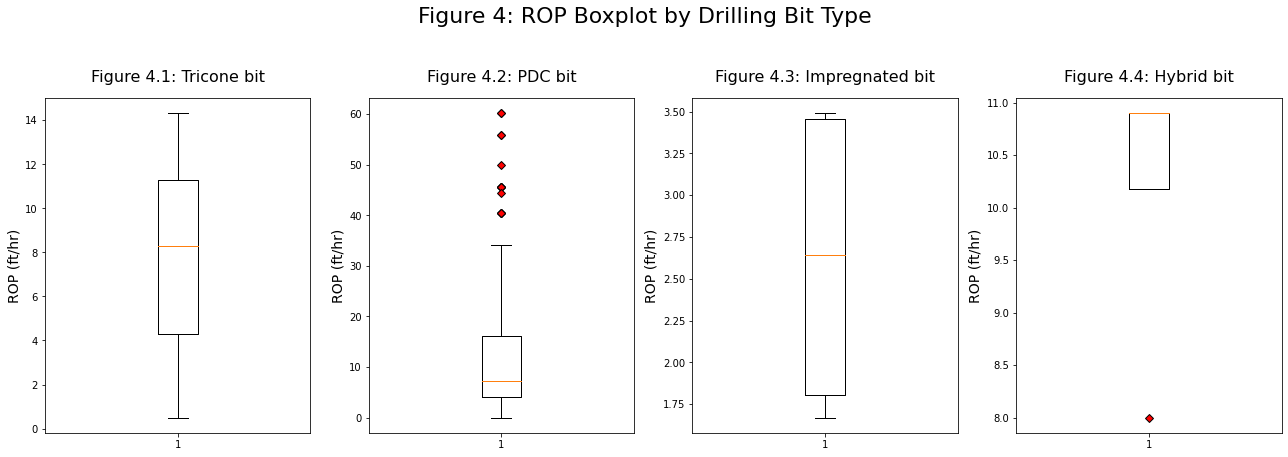

In [25]:
bit_types=['Tricone', 'PDC', 'Impregnated', 'Hybrid']
nums=np.arange(1,5)

fig4, axs = plt.subplots(figsize=(18, 6), nrows=1, ncols=4)

for bit, num, axe in zip(bit_types, nums, axs):
    axe.boxplot(df.loc[df.Type==bit]['ROP'], vert=True, notch=False, 
                flierprops=outliers, patch_artist=False )
    axe.set_ylabel('ROP (ft/hr)', fontsize=14)    
    axe.set_title('Figure 4.{}: {} bit'.format(num,bit), fontsize=16, fontweight='light',
              loc='Center', y=1.03)

plt.suptitle('Figure 4: ROP Boxplot by Drilling Bit Type', y=1.05, fontsize=22)
plt.tight_layout()  
plt.show()

And what about categorical features? yes, We can apply generate some plot for those as well. Let's take the `Type` column and visualize the count using **Bar plots**

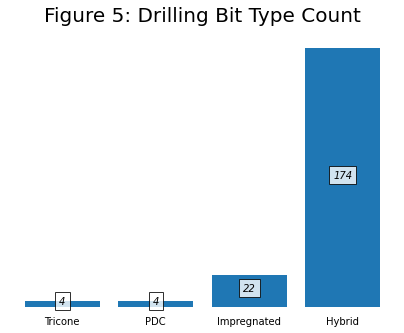

In [26]:
fig5, axe = plt.subplots(figsize=(7, 5))

# Bit types
bit_types=['Tricone', 'PDC', 'Impregnated', 'Hybrid']

# function to add value labels
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i]//2, y[i], ha = 'center', 
                 fontstyle ='italic',
                 Bbox = dict(facecolor = 'white', alpha =.8))

        
        
# Remove axes splines
for s in ['top', 'bottom', 'left', 'right']:
    axe.spines[s].set_visible(False)

# Remove x, y ticks
axe.xaxis.set_ticks_position('none')
axe.yaxis.set_ticks_position('none')
   
# Add padding between axes and labels
axe.xaxis.set_tick_params(pad = 5)
axe.yaxis.set_tick_params(pad = 10)

        
# ploting
axe.bar(bit_types,df.Type.value_counts().sort_values())
axe.axes.get_yaxis ().set_visible (False)
addlabels(bit_types, df.Type.value_counts().sort_values())


axe.set_title('Figure 5: Drilling Bit Type Count', fontsize=20, loc='Center', y=1.03)    
plt.show()

Another way to show the distribution of a categorical parameter is a **Pieµµ or **Doughnut** graph. Although generally reffered to as less visually effective, we'll see why later on.

## 2.4 Investigating parameters relationship (Correlation)
Correlation shows the strength of a relationship between two variables and is expressed numerically by the correlation coefficient, which can range between -1.0 and 1.0. A perfect positive correlation means that the correlation coefficient is exactly 1.

Multiple graphs can be used to examine the latter, amidts the most utilized are the **Scatter**, **Heatmap**, and **2D-Density** plots.
- A scatter plot (aka scatter chart, scatter graph) uses dots to represent values for two different numeric variables. The position of each dot on the horizontal and vertical axis indicates values for an individual data point. Scatter plots are used to observe relationships between variables.
- A heatmap is simply a color coded table which contains the correlation values of all the parameters.
- A 2D density plot, shows not only the overall relationship of the parameters, but where it's most dense or foculized.

Let's start with the correlation heatmap to get a general idea about the coorelation values.

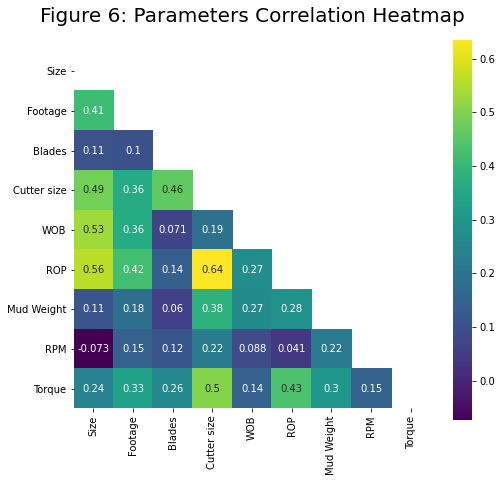

In [27]:
# Create the figure
fig6, axe = plt.subplots(figsize=(8, 7))

# Calculate correlation between each pair of variable
corr_matrix=df.corr(method='spearman')
 
# Generate a mask for the upper triangle
mask = np.zeros_like(corr_matrix)
mask[np.triu_indices_from(mask)] = True

# Draw the heatmap with the mask
sns.heatmap(corr_matrix, mask=mask, square=True, 
            annot=True, annot_kws={"size": 10}, 
            ax=axe, cmap="viridis", robust=False)

axe.set_title('Figure 6: Parameters Correlation Heatmap', fontsize=20, loc='Center', y=1.065)    
plt.show()

Note that most of the parameters in the data itself have been averaged for each individual drill bit, which means that we are not really quantifying the relationship of the parameters but their averages (keep that in mind).

Regardless, it appears that there is a positive correlation between cutting tool size, bit size and the parameter of interest, ROP. Positive means that the higher these characteristics are, the higher the ROP tends to be.

**Note:**
- Being a drilling engineer myself, I can assume that this is not a direct relationship but rather a result of usage. To be clear, larger drill bits tend to be used in shallow formations where the lithology is less compact or dense compared to deeper depths. And when it comes to drill bit size, the softer the formation, the more the tendency is to use a longer blade for drilling, because softer means a lower probability of breakage and longer means faster drilling. 
- Although this is not a cause and effect relationship, it is worth mentioning that despite the complex nature of the formation being drilled, the engineers who selected the drill bit did an excellent job since, of the 204 drill bits selected, 64% of the situations were near optimal, which is a real challenge.

That's why I still say context is key, but regardless, let's use this data for learning purposes.

In [28]:
df

,Size,Manufacturer,Type,Footage,Blades,Cutter size,WOB,ROP,Mud Weight,RPM,Torque
0,36.0,A,Tricone,82,3,0,13.0,10.10,8.5,80,5.0
1,26.0,A,Tricone,709,3,0,78.0,11.29,8.5,73,11.0
2,26.0,A,Tricone,547,3,0,78.0,11.29,8.5,73,11.0
3,26.0,A,Tricone,438,3,0,55.0,14.32,9.6,168,13.0
4,26.0,C,Tricone,320,3,0,55.0,14.32,9.6,168,13.0
...,...,...,...,...,...,...,...,...,...,...,...
199,8.5,D,PDC,219,7,13,30.0,6.10,8.2,120,8.0
200,8.5,B,PDC,97,8,13,45.0,2.50,8.2,115,9.0
201,8.5,B,PDC,198,8,13,35.0,4.00,8.3,130,9.0
202,8.5,A,PDC,56,8,13,30.0,5.00,8.4,135,8.5


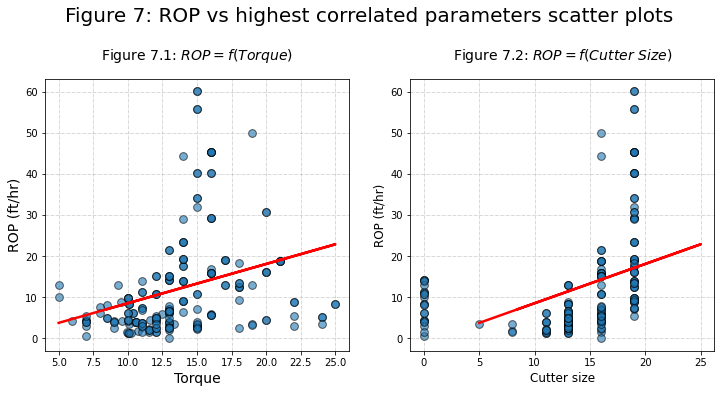

In [29]:
# Initialize layout
fig7, axs = plt.subplots(figsize = (12, 5), nrows=1, ncols=2)

# Set the variables
x1= df['Torque']
x2= df['Cutter size']
y= df.ROP

# Add scatterplot
axs[0].scatter(x1, y, s=60, alpha=0.6, edgecolors="k")
axs[1].scatter(x2, y, s=60, alpha=0.6, edgecolors="k")

# Fit linear regression via least squares with numpy.polyfit
a1, b1 = np.polyfit(x1, y, deg=1)
a2, b2 = np.polyfit(x2, y, deg=1)

# Plot regression line
axs[0].plot(x1, a1*x1+b1, color='red', lw=2.5)
axs[1].plot(x1, a1*x1+b1, color="red", lw=2.5)

# Set titles
axs[0].set_title('Figure 7.1: $ROP= f(Torque)$', fontsize=14, loc='Center', y=1.05)    
axs[1].set_title('Figure 7.2: $ROP= f(Cutter~Size)$', fontsize=14, loc='Center', y=1.05)    

# Set axis
axs[0].set_xlabel('Torque', fontsize=14)
axs[0].set_ylabel('ROP (ft/hr)', fontsize=14)
axs[1].set_xlabel('Cutter size', fontsize=12)
axs[1].set_ylabel('ROP (ft/hr)', fontsize=12)


# Add grid lines
axs[0].grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.6)

axs[1].grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.6)


#Set figure title
plt.suptitle('Figure 7: ROP vs highest correlated parameters scatter plots', fontsize=20, y=1.08)
plt.show()

Before we go on, we need to clarify one thing and make sure to keep this in mind (**Correlation does not equal Causation**), just because we see a trend in the data does not mean it has to be so.

Let's take the same graph, remove the trend lines and locate the Mean values.

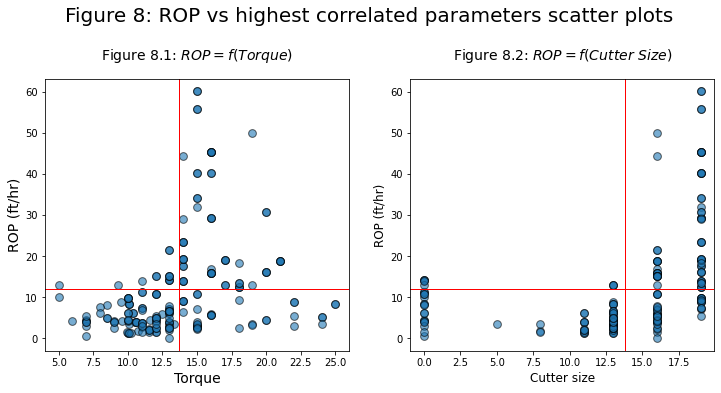

In [30]:
# Initialize layout
fig8, axs = plt.subplots(figsize = (12, 5), nrows=1, ncols=2)

# Set the variables
x1= df['Torque']
x2= df['Cutter size']
y= df.ROP

# Add scatterplot
axs[0].scatter(x1, y, s=60, alpha=0.6, edgecolors="k")
axs[1].scatter(x2, y, s=60, alpha=0.6, edgecolors="k")


# Set titles
axs[0].set_title('Figure 8.1: $ROP= f(Torque)$', fontsize=14, loc='Center', y=1.05)    
axs[1].set_title('Figure 8.2: $ROP= f(Cutter~Size)$', fontsize=14, loc='Center', y=1.05)    

# Set axis
axs[0].set_xlabel('Torque', fontsize=14)
axs[0].set_ylabel('ROP (ft/hr)', fontsize=14)
axs[1].set_xlabel('Cutter size', fontsize=12)
axs[1].set_ylabel('ROP (ft/hr)', fontsize=12)

# Locate the mean values
axs[0].axhline(y.mean(), color='red', lw=1)
axs[0].axvline(x1.mean(), color='red', lw=1)
axs[1].axhline(y.mean(), color='red', lw=1)
axs[1].axvline(x2.mean(), color='red', lw=1)

#Set figure title
plt.suptitle('Figure 8: ROP vs highest correlated parameters scatter plots', fontsize=20, y=1.08)
plt.show()

Notice points tendency around the intersection of the mean values.

The most beautiful thing about inspecting data through programming is it's degree of flexibility, as an example let's combine the Heatmap and Scatter tendency in a single graph.

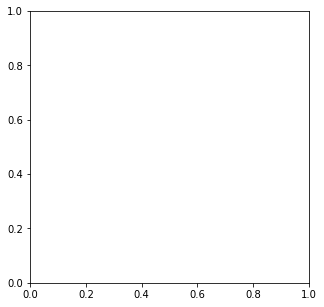

In [31]:
fig9, axes = plt.subplots(figsize=(5, 5))

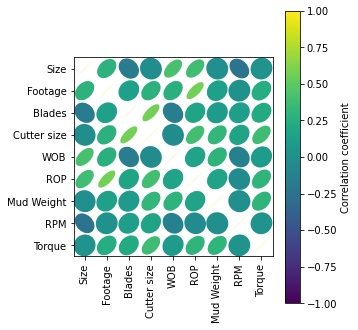

In [32]:
def plot_corr_ellipses(data, figsize=None, **kwargs):
    ''' https://stackoverflow.com/a/34558488 '''
    M = np.array(data)
    if not M.ndim == 2:
        raise ValueError('data must be a 2D array')
    fig, ax = plt.subplots(1, 1, figsize=figsize, subplot_kw={'aspect':'equal'})
    ax.set_xlim(-0.5, M.shape[1] - 0.5)
    ax.set_ylim(-0.5, M.shape[0] - 0.5)
    ax.invert_yaxis()

    # xy locations of each ellipse center
    xy = np.indices(M.shape)[::-1].reshape(2, -1).T

    # set the relative sizes of the major/minor axes according to the strength of
    # the positive/negative correlation
    w = np.ones_like(M).ravel() + 0.01
    h = 1 - np.abs(M).ravel() - 0.01
    a = 45 * np.sign(M).ravel()

    ec = EllipseCollection(widths=w, heights=h, angles=a, units='x', offsets=xy,
                           norm=Normalize(vmin=-1, vmax=1),
                           transOffset=ax.transData, array=M.ravel(), **kwargs)
    ax.add_collection(ec)

    # if data is a DataFrame, use the row/column names as tick labels
    if isinstance(data, pd.DataFrame):
        ax.set_xticks(np.arange(M.shape[1]))
        ax.set_xticklabels(data.columns, rotation=90)
        ax.set_yticks(np.arange(M.shape[0]))
        ax.set_yticklabels(data.index)

    return ec, ax

m, ax = plot_corr_ellipses(df.corr(), figsize=(5, 5), cmap='viridis')
cb = fig9.colorbar(m, ax=ax)
cb.set_label('Correlation coefficient')

plt.tight_layout()
plt.show()

- The narrowness of the elipse indicates the magnitude of the correlation.
- The orientation of the eclipse shows the trend of the relationship.

That's cool, right! 

Another key term to remember is that when we look at each parameter individually (histogram, density, etc.), it is a **Univariate analysis**.

When we look at the relationships between several parameters, 2 or more. This is called **Bi-variant analysis**, and **Multi-functional analysis** respectively.

Although scatter plots are extremely useful, it is sometimes difficult to get the full picture when the number of data points is large (and it usually is), especially when we are not able to locate where the data tend to cluster.

Fortunately, there are charts more dedicated to this aspect, namely the **Hexagonal binning** and **Contour** plots. Let's introduce a larger data set and see how to use them.

In [33]:
# Let's import a well log using lasio
las = lasio.read("Data/Well_log.las")

# convert the las file to a pandas DataFrame
df1= las.df()
df1.dropna(inplace=True)

In [34]:
# Let's take a quick look
df1.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 6951 entries, 3550.2068 to 4617.9212
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AC      6951 non-null   float64
 1   CALI    6951 non-null   float64
 2   DEN     6951 non-null   float64
 3   GR      6951 non-null   float64
 4   NEU     6951 non-null   float64
 5   RDEP    6951 non-null   float64
 6   RMED    6951 non-null   float64
dtypes: float64(7)
memory usage: 434.4 KB


In [35]:
# Let's lookup the curves
for count, curve in enumerate(las.curves):
    print(f"Curve: {curve.mnemonic}, Units: {curve.unit}, Description: {curve.descr}")
print(f"There are a total of: {count+1} curves present within this file")

Curve: DEPT, Units: M, Description: 1  DEPTH
Curve: AC, Units: US/F, Description: 2  Sonic Transit Time (Slowness)
Curve: CALI, Units: IN, Description: 3  Caliper
Curve: DEN, Units: G/CC, Description: 4  Bulk Density
Curve: GR, Units: GAPI, Description: 5  Gamma Ray
Curve: NEU, Units: %, Description: 6  Neutron Porosity
Curve: RDEP, Units: OHMM, Description: 7  Deep Resistivity
Curve: RMED, Units: OHMM, Description: 8  Medium Resistivity
There are a total of: 8 curves present within this file


As you can see, this data contains 29754 entries. let's plot the relationship between the **bulk density** `DEN` and the **neutron porosity** `NEU` using a Scatter, a Hexagonal binning and  a Contour plot and see how they compare.

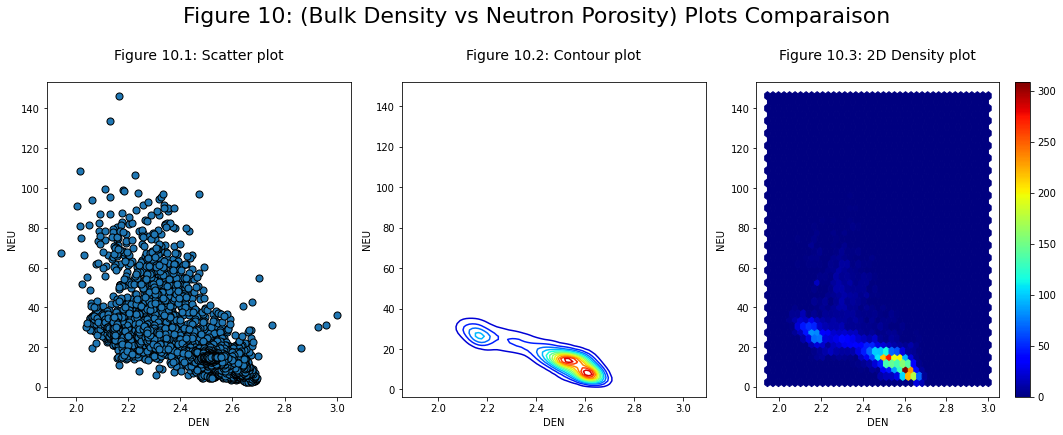

In [36]:
# Create the figure
fig10, axes = plt.subplots(figsize=(15, 6), nrows=1, ncols=3)

# Plot the graphs
axes[0].scatter(df1.DEN, df1.NEU, s=50, edgecolors="k")
sns.kdeplot(data= df1['DEN'], data2=df1['NEU'], cmap="jet", levels=15, ax=axes[1])
df1.plot.hexbin(x='DEN', y='NEU', gridsize=40, cmap=plt.cm.jet, ax=axes[2])

# Set titles
axes[0].set_title('Figure 10.1: Scatter plot', fontsize=14, loc='Center', y=1.05)    
axes[1].set_title('Figure 10.2: Contour plot', fontsize=14, loc='Center', y=1.05)   
axes[2].set_title('Figure 10.3: 2D Density plot', fontsize=14, loc='Center', y=1.05)    

# Set axis
axes[0].set_xlabel('DEN')
axes[0].set_ylabel('NEU')


#Set figure title
plt.suptitle('Figure 10: (Bulk Density vs Neutron Porosity) Plots Comparaison', fontsize=22, y=1)
plt.tight_layout()
plt.show()

Rather than plotting points, which would appear as a monolithic dark cloud such is in the Scatter, we grouped the records into hexagonal bins and plotted the hexagons with a color indicating the number of records in that bin.

The Contour plot in another hand is essentially a topographical map to two variables; each contour band represents a specific density of points, increasing as one nears a “peak.”

Alright, enough with numerical variables for the moment let's jump back to some categorical data.

Previously we mentionned how combining pandas `loc` and visuals can generate quite intresting insights, We'll see how we can effectively use it. let's add an extra layer to the previous ROP boxplot, and see which company bit performed the best. 

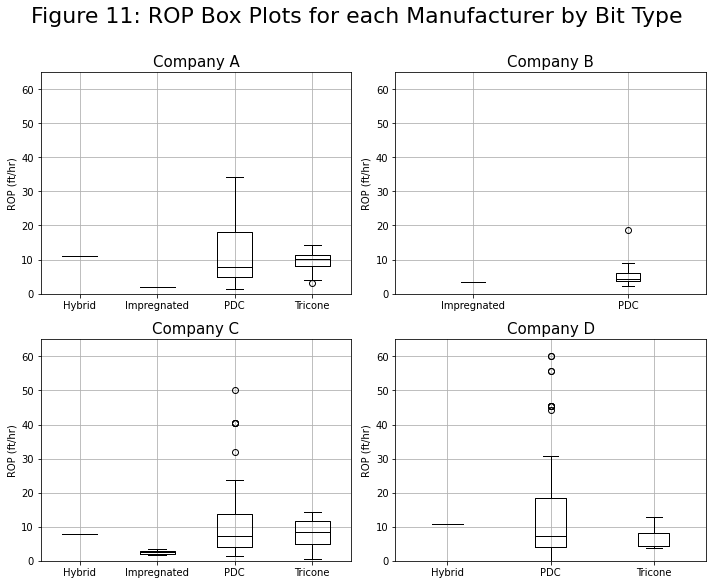

In [37]:
# Create the figure
fig11, axes = plt.subplots(figsize=(10, 8), nrows=2, ncols=2)

# Plotting the graphs
df.loc[df.Manufacturer=='A'].boxplot(by='Type', column='ROP', ax=axes[0,0], color='black')
df.loc[df.Manufacturer=='B'].boxplot(by='Type', column='ROP', ax=axes[0,1], color='black')
df.loc[df.Manufacturer=='C'].boxplot(by='Type', column='ROP', ax=axes[1,0], color='black')
df.loc[df.Manufacturer=='D'].boxplot(by='Type', column='ROP', ax=axes[1,1], color='black')


# Setting limits to avoid bias
axes[0,0].set_ylim(0,65)
axes[0,1].set_ylim(0,65)
axes[1,0].set_ylim(0,65)
axes[1,1].set_ylim(0,65)

# Setting titles
axes[0,0].set_title("Company A", fontsize=15)
axes[0,1].set_title("Company B", fontsize=15)
axes[1,0].set_title("Company C", fontsize=15)
axes[1,1].set_title("Company D", fontsize=15)

# Setting labels
axes[0,0].set_xlabel(None)
axes[0,1].set_xlabel(None)
axes[1,0].set_xlabel(None)
axes[1,1].set_xlabel(None)
axes[0,0].set_ylabel('ROP (ft/hr)')
axes[0,1].set_ylabel('ROP (ft/hr)')
axes[1,0].set_ylabel('ROP (ft/hr)')
axes[1,1].set_ylabel('ROP (ft/hr)')


# Setting Figure
plt.suptitle('Figure 11: ROP Box Plots for each Manufacturer by Bit Type', fontsize= 22, y=1.01)
plt.tight_layout()
plt.show()

**Remarks:**
- In some cases, the bit types are not present in the graph because no bits of that type belonging to the company in question were recorded in the data set.
- Tricon bits, regardless of manufacturer, show similar ROP performance.
- Company 'D' PDCs recorded the highest ROP.

**Interpretation:**
- It would not be fair to conclude that one company's bit is better than its counterparts, performance is not just about ROP, especially when it is just an average scaler value. You have to take into account the wear of the bit, the duration of the drilling, the distance covered, etc.

Another similar visual to the Boxplot is the Violin plot, in fact the latter is considered an enhancement of it, The density is mirrored
and flipped over, and the resulting shape is filled in, creating an image resembling a violin. The advantage of a violin plot is that it can show nuances in the distribution that aren’t perceptible in a boxplot. On the other hand, the boxplot more clearly shows the outliers in the data. 

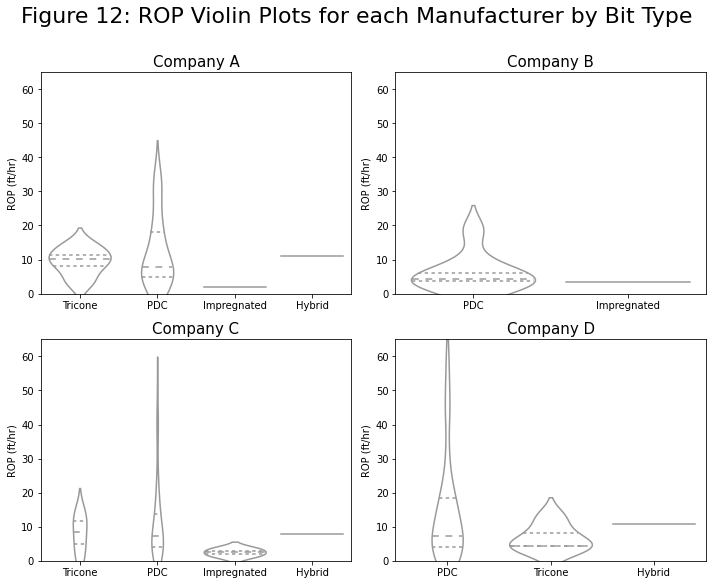

In [38]:
# Create the figure
fig12, axes = plt.subplots(figsize=(10, 8), nrows=2, ncols=2)

# Plotting the graphs
sns.violinplot(data=df.loc[df.Manufacturer=='A'], x='Type', y='ROP',
               inner='quartile', ax=axes[0,0], color='white')
sns.violinplot(data=df.loc[df.Manufacturer=='B'], x='Type', y='ROP',
               inner='quartile', ax=axes[0,1], color='white')
sns.violinplot(data=df.loc[df.Manufacturer=='C'], x='Type', y='ROP',
               inner='quartile', ax=axes[1,0], color='white')
sns.violinplot(data=df.loc[df.Manufacturer=='D'], x='Type', y='ROP',
               inner='quartile', ax=axes[1,1], color='white')


# Setting limits to avoid bias
axes[0,0].set_ylim(0,65)
axes[0,1].set_ylim(0,65)
axes[1,0].set_ylim(0,65)
axes[1,1].set_ylim(0,65)

# Setting titles
axes[0,0].set_title("Company A", fontsize=15)
axes[0,1].set_title("Company B", fontsize=15)
axes[1,0].set_title("Company C", fontsize=15)
axes[1,1].set_title("Company D", fontsize=15)

# Setting labels
axes[0,0].set_xlabel(None)
axes[0,1].set_xlabel(None)
axes[1,0].set_xlabel(None)
axes[1,1].set_xlabel(None)
axes[0,0].set_ylabel('ROP (ft/hr)')
axes[0,1].set_ylabel('ROP (ft/hr)')
axes[1,0].set_ylabel('ROP (ft/hr)')
axes[1,1].set_ylabel('ROP (ft/hr)')


# Setting Figure
plt.suptitle('Figure 12: ROP Violin Plots for each Manufacturer by Bit Type', fontsize= 22, y=1.01)
plt.tight_layout()
plt.show()

For Excell enthusiasts who are familiar with pivot tables, this feature allows you to group data points by different indices and offers great utility for in-depth analysis. Luckily, pandas has this method available if you wanna give it a try, here's a brief example of Mean calculation by Type and Manufacturer.

In [39]:
cross_table=df.pivot_table(index='Manufacturer', columns='Type', 
               aggfunc='mean', margins=True)

cross_table

Blades                                         Cutter size  \
Type         Hybrid Impregnated       PDC Tricone       All      Hybrid   
Manufacturer                                                              
A               3.0        18.0  7.291667     3.0  6.277778        16.0   
B               NaN        12.0  7.750000     NaN  8.222222         NaN   
C               3.0        12.0  7.612903     3.0  7.164384        16.0   
D               3.0         NaN  7.125000     3.0  6.837209        16.0   
All             3.0        13.5  7.350575     3.0  6.916667        16.0   

                                                        ... Torque  \
Type         Impregnated        PDC Tricone        All  ... Hybrid   
Manufacturer                                            ...          
A                   8.00  15.666667     0.0  11.555556  ...  12.00   
B                   8.00  14.500000     NaN  13.777778  ...    NaN   
C                   6.50  15.741935     0.0  13.767123  ...  13.00   
D                    NaN  15.725000     0.0  14.813953  ...  12.00   
All                 7.25  15.666667     0.0  13.818627  ...  12.25   

                                                             WOB              \
Type         Impregnated        PDC    Tricone        All Hybrid Impregnated   
Manufacturer                                                                   
A                10.7000  12.787500  10.833333  12.197222   70.0        20.0   
B                19.0000  12.937500        NaN  13.611111    NaN        21.0   
C                10.0250  14.225000  11.750000  13.821918   70.0         6.5   
D                    NaN  14.528250  10.600000  14.270465   70.0         NaN   
All              12.4375  14.106954  11.113636  13.715000   70.0        13.5   

                                               
Type                PDC    Tricone        All  
Manufacturer                                   
A             29.125000  48.222222  35.916667  
B             38.750000        NaN  36.777778  
C             32.580645  46.875000  33.945205  
D             31.362500  40.600000  32.348837  
All           31.827586  46.000000  33.745098  

[5 rows x 45 columns]

Exploratory data analysis (EDA), set a foundation for the field of data science. The key idea of EDA is that the first and most important step in
any project based on data is to look at the data. By summarizing and visualizing the data, you can gain valuable intuition and understanding of the project.
___

# 3. Representative selection and data distributions
Representative data selection refers to an **unbiased** sampling of a data set from a larger set of points called **population**, why is this important? Well, depending on the study case being addressed, this may be crucial, the idea is when you set up an analysis, you want to apply it to a subset (that you usually have) that represents the population (that you don't have access to). So that the results of your survey are actually reliable. Further more, a bias within the data intentional or not, would ruin the prediction ability of any machine learning model when deployed on the real world.

## 3.1 Sampling an introduction to key conecpts
Let's first define some key concepts needed to navigate this section:


**Does the size of the data matter?**
In most cases, the quality of the data is more important than the quantity, there is usually some kind of threshold between the two, because the higher the number of points, the more difficult it is to ensure consistency and to investigate possible missing attributes, but by reducing the number of points, you risk losing important information It should also be noted that for higher data sizes, the computation can become very expensive very quickly.

**What is Bias?**
Statistical bias refers to measurement or sampling errors that are systematic and produced by the measurement or sampling process. An important distinction should be made between errors due to random chance and errors due to bias.

**What are the types of stistical Bias?**
When it comes to statistics, six main groups of bias have been identified, each representing a distinct set. You can read more about this topic by clicking here [Bias types](https://builtin.com/data-science/types-of-bias-in-statistics):
- *Selection bias*: Selection bias is the phenomenon of selecting "individuals, groups, or data for analysis in such a way that proper randomization is not performed, ultimately resulting in a sample that is not representative of the population."
- *Survivorship bias*: Survivorship bias is when only those who have survived a long process are included or excluded in an analysis, creating a biased sample.
- *Omitted variable bias*: This bias comes from the absence of relevant variables in a model. In machine learning, removing relevant variables and/or too many variables results in an under-fitted model.
- *Recall bias*: Recall bias is a type of information bias where people do not remember previous events, memories or details. It is related to recency bias, in which we tend to remember things that happened more recently.
- *Observer bias*: This bias stems from the subjective viewpoint of observers and how they evaluate subjective criteria or record subjective information.
- *Funding bias*: Also known as sponsorship bias, funding bias is the tendency to bias a study or study results to support a financial sponsor.

**How to avoid bias?**
Use **Random sampling**, This is a selection technique that ensures a representative subset of the population. Randomness means that every observation in the data has an equal chance of being drawn, so we do not have to select instances ourselves.

**Data distribution and sampling distribution, what's the difference?**
We already look at **Data Distribution** for a parameter in an attempt to examine it's spread and skewness, in the other hand **Sampling Distribution** is The frequency distribution of a **Sample Statistic** (metric calculated for a sample) such as the mean, median, etc. Let's clarify it with an example.

In [40]:
# Let's take the well log data
sample_data = pd.DataFrame({
    'GR': df1.GR.sample(1000),
    'type': 'Data',
})

sample_mean_05 = pd.DataFrame({
    'GR': [df1.GR.sample(5).mean() for _ in range(1000)],
    'type': 'Mean of 5',
})

sample_mean_20 = pd.DataFrame({
    'GR': [df1.GR.sample(20).mean() for _ in range(1000)],
    'type': 'Mean of 20',
})

results = pd.concat([sample_data, sample_mean_05, sample_mean_20])

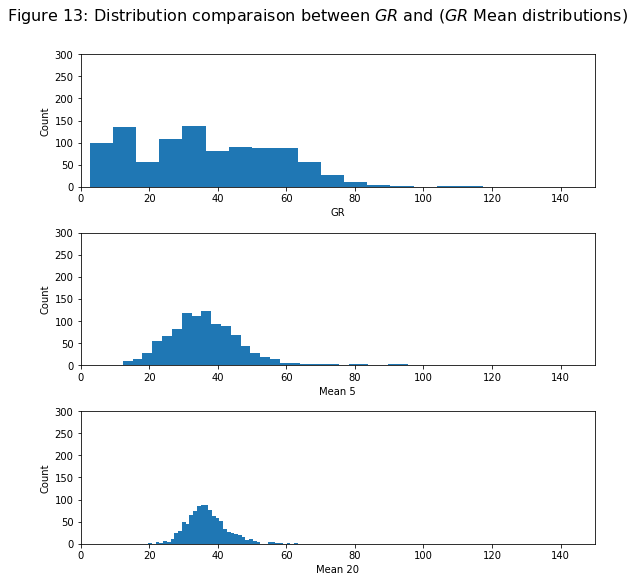

In [41]:
# Create the figure
fig13, axes = plt.subplots(figsize=(8, 8), nrows=3, ncols=1)

indeces =  [0,1,2]
Data = [sample_data, sample_mean_05, sample_mean_20]
titles= ['GR', 'Mean 5', 'Mean 20']

for index, data,title in zip(indeces, Data, titles):
    axes[index].hist(data.GR, bins=40)
    axes[index].set_xlabel(title)

# Setting labels
axes[0].set_xlabel('GR')
axes[1].set_xlabel('Mean 5')
axes[2].set_xlabel('Mean 20')

for ax in axes:
    ax.set_ylabel('Count')
    ax.set_ylim(0,300)
    ax.set_xlim(0,150)

# Setting Figure
plt.suptitle('Figure 13: Distribution comparaison between $GR$ and ($GR$ Mean distributions)', fontsize= 16, y=1.005)
plt.tight_layout()
plt.show()

The histogram of the individual data values is broadly spread out and skewed toward higher values, as is to be expected with income data. The histograms of the means of 5 and 20 are increasingly compact and more bell-shaped. 

**What's the Central Limit Theorem?**
The phenomenon we’ve just described is termed the **central limit theorem**. It says that the means drawn from multiple samples will resemble the familiar bell-shaped normal curve, even if the source population is not normally distributed, provided that the sample size is large enough and the departure of the data from normality is not too great. 

The central limit theorem allows normal-approximation formulas like the t-distribution to be used in calculating sampling distributions for inference—that is, confidence intervals and hypothesis tests.

**Standard Deviation and Standard Error, what's the difference?**
Well similar to the previous example, standard deviation measures the variability of individual data points, with standard error measures the variability of a sample metric.

**Resampling and Bootstrapping, what's the difference?**
Sometimes the term resampling is used synonymously with the term bootstrapping, as just outlined. More often, the term resampling also includes permutation procedures, where multiple samples are combined and the sampling may be done without replacement.

- The bootstrap (sampling with replacement from a data set) is a powerful tool for assessing the variability of a sample statistic, it can be applied in similar fashion in a wide variety of circumstances, without extensive study of mathematical approximations to sampling distributions.
- It also allows us to estimate sampling distributions for statistics where no mathematical approximation has been developed.
- When applied to predictive models, aggregating multiple bootstrap sample predictions (bagging) outperforms the use of a single model.

In [42]:
# Bootstrapping example
results = []
for nrepeat in range(2000):
    sample = resample(df1.GR)
    results.append(sample.median())
results = pd.Series(results)
print('Bootstrap Statistics:')
print(f'original: {df1.GR.median()}')
print(f'bias: {results.mean() - df1.GR.median()}')
print(f'std. error: {results.std()}')

Bootstrap Statistics:
original: 33.0777
bias: -0.04082935000000276
std. error: 0.369762231964909


How to interpret these results? The original estimate of the median is 33. The bootstrap distribution indicates that the estimate has a bias of about –0.06 and a standard error of 0.37. The results will vary slightly between consecutive runs of the algorithm.

Note that the bootstrap does not compensate for a small sample size; it does not create new data, nor does it fill in holes in an existing data set. It merely informs us about how lots of additional samples would behave when drawn from a population like our original sample.

**What's Confidence Intervals?**
Just like histograms, boxplots and standard errors, C.I is a tool to understand the potential error in a sample estimate.
Rather than presenting only a specific value for an estimation, you give a value range with a degree of confidence define by a low and high value typically (90% and 95%).

More generally, an y% confidence interval around a sample estimate should, on average, contain similar sample estimates y% of the time.

When it comes to a data science project, a confidence interval is a tool that can be used to get an idea of how variable a sample result might be. This is employed generally in communicating the potential error in an estimate, and perhaps to learn whether a larger sample is needed.

36.77381768090924
33.620435


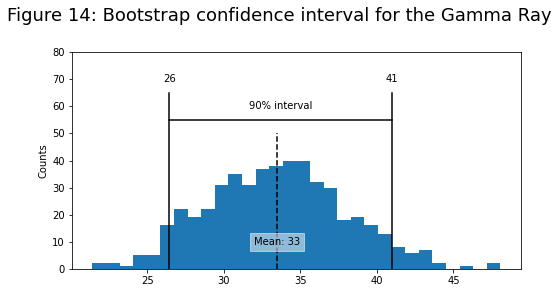

In [43]:
# Confidence Level visualization
print(df1.GR.mean())
np.random.seed(seed=3)  

# create a sample of 20 log Gamma Ray data
sample20 = resample(df1.GR, n_samples=20, replace=False)
print(sample20.mean())
results = []
for nrepeat in range(500):
    sample = resample(sample20)
    results.append(sample.mean())
results = pd.Series(results)

confidence_interval = list(results.quantile([0.05, 0.95]))
ax = results.plot.hist(bins=30, figsize=(7, 4))
ax.plot(confidence_interval, [55, 55], color='black')
for x in confidence_interval:
    ax.plot([x, x], [0, 65], color='black')
    ax.text(x, 70, f'{x:.0f}', 
            horizontalalignment='center', verticalalignment='center')
ax.text(sum(confidence_interval) / 2, 60, '90% interval',
        horizontalalignment='center', verticalalignment='center')

mean = results.mean()
ax.plot([mean, mean], [0, 50], color='black', linestyle='--')
ax.text(mean, 10, f'Mean: {mean:.0f}',
        bbox=dict(facecolor='white', edgecolor='white', alpha=0.5),
        horizontalalignment='center', verticalalignment='center')
ax.set_ylim(0, 80)
ax.set_ylabel('Counts')



# Setting Figure
plt.suptitle('Figure 14: Bootstrap confidence interval for the Gamma Ray', fontsize= 18, y=1.005)
plt.tight_layout()
plt.show()

## 3.2 A guide for data distribution types
Some data distributions are observable quite repeatedly in natural processes, I find that having an eye for recognizing the general type facilitates both insight extraction and data processing. Therefore, we will look at the most commonly encountered ones with some key characteristics.

### 3.2.1 Gaussian / Normal or Bell Shaped distribution
A common misconception about a **normal** distribution is that it is some sort of norm among data parameters. In fact, most raw data as a whole are **not** normally distributed. Its usefulness stems from the fact that many statistics are normally distributed in their **sampling**, as we saw earlier.

A key characteristic of the a normal distribution is that the units on the x-axis are expressed in terms of standard deviations away from the mean. To compare data to a standard normal distribution, you subtract the mean and then divide by the standard deviation; this is also called normalization or standardization

<img src="https://www.freecodecamp.org/news/content/images/2020/08/normal_dist_68_rule.jpg" alt="Joint-representation" />


Let's look up an example using a Histogram and a QQ plot.

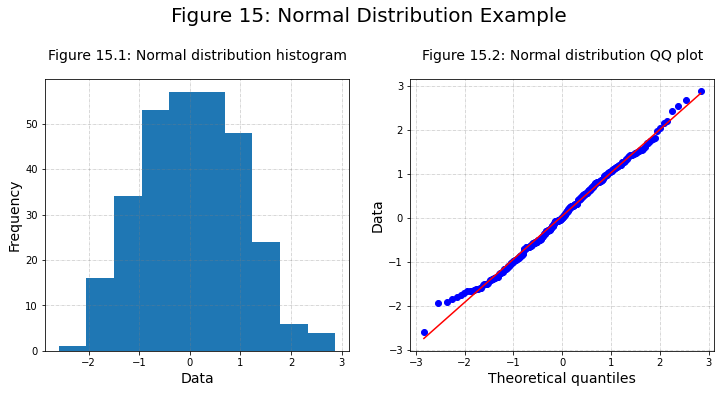

In [44]:
# Let's create an example of a normal distribution
norm_sample = stats.norm.rvs(size=300)

# Initialize layout
fig15, axs = plt.subplots(figsize = (12, 5), nrows=1, ncols=2)

# Add scatterplot
axs[0].hist(norm_sample)
stats.probplot(norm_sample, plot=axs[1])

# Set titles
axs[0].set_title('Figure 15.1: Normal distribution histogram', fontsize=14, loc='Center', y=1.05)    
axs[1].set_title('Figure 15.2: Normal distribution QQ plot', fontsize=14, loc='Center', y=1.05)    

# Set axis
axs[0].set_xlabel('Data', fontsize=14)
axs[0].set_ylabel('Frequency', fontsize=14)
axs[1].set_xlabel('Theoretical quantiles', fontsize=14)
axs[1].set_ylabel('Data', fontsize=14)



# Add grid lines
for ax in axs:
    ax.grid(b = True, color ='grey',
            linestyle ='-.', linewidth = 0.5,
            alpha = 0.6)

#Set figure title
plt.suptitle('Figure 15: Normal Distribution Example', fontsize=20, y=1.08)
plt.show()

plt.show()

Alright, we've seen histograms before but what's a QQ plot (cute name right hh), In statistics, a Q–Q plot (quantile-quantile plot) is a probability plot, a graphical method for comparing two probability distributions by plotting their quantiles against each other. If the points roughly fall on the diagonal line, then the sample distribution can be considered close to normal.

An additional not, the following distribution is refered to as a **Standard normal**, because the $Mean=0$ And $St.D=1$

### 3.2.2 Long-Tailed distributions
As we previously said and in contrast to what the term **Nomral** might suggest, most of world data is not normally distributed. In major times the parameter investigated is skewed to an extreem, such is the case with the **Rate of penetration** example we've seen in figure 2. Let's visualize it's QQ-plot and see how it differs from the initial one.

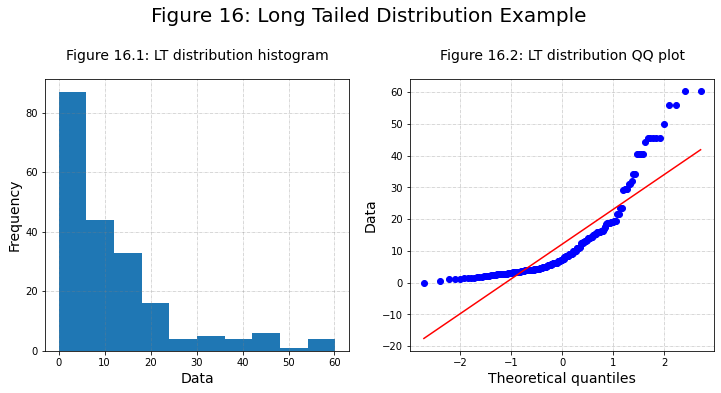

In [45]:
# Initialize layout
fig16, axs = plt.subplots(figsize = (12, 5), nrows=1, ncols=2)

# Add scatterplot
axs[0].hist(df.ROP)
stats.probplot(df.ROP, plot=axs[1])

# Set titles
axs[0].set_title('Figure 16.1: LT distribution histogram', fontsize=14, loc='Center', y=1.05)    
axs[1].set_title('Figure 16.2: LT distribution QQ plot', fontsize=14, loc='Center', y=1.05)    

# Set axis
axs[0].set_xlabel('Data', fontsize=14)
axs[0].set_ylabel('Frequency', fontsize=14)
axs[1].set_xlabel('Theoretical quantiles', fontsize=14)
axs[1].set_ylabel('Data', fontsize=14)



# Add grid lines
for ax in axs:
    ax.grid(b = True, color ='grey',
            linestyle ='-.', linewidth = 0.5,
            alpha = 0.6)

#Set figure title
plt.suptitle('Figure 16: Long Tailed Distribution Example', fontsize=20, y=1.08)
plt.show()

plt.show()

The points are far beyond the line in both extreems, indicating the data are not normally distributed. This means that we are much more likely to observe extreme values than would be expected if the data had a normal distribution.

### 3.2.3 Binomial distribution
The binomial distribution is the frequency distribution of the number of successes (x) in a given number of trials (n) with specified probability (p) of success in each trial. There is a family of binomial distributions, depending on the values of n and p.

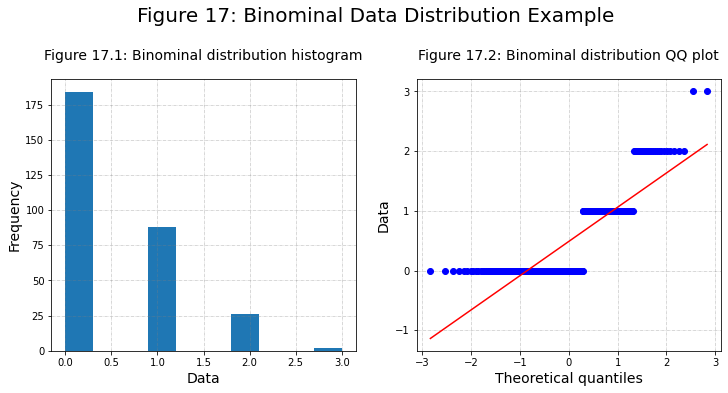

In [46]:
binom_sample=stats.binom.rvs(size=300,  n=5, p=0.1)

# Initialize layout
fig17, axs = plt.subplots(figsize = (12, 5), nrows=1, ncols=2)

# Add scatterplot
axs[0].hist(binom_sample)
stats.probplot(binom_sample, plot=axs[1])

# Set titles
axs[0].set_title('Figure 17.1: Binominal distribution histogram', fontsize=14, loc='Center', y=1.05)    
axs[1].set_title('Figure 17.2: Binominal distribution QQ plot', fontsize=14, loc='Center', y=1.05)    

# Set axis
axs[0].set_xlabel('Data', fontsize=14)
axs[0].set_ylabel('Frequency', fontsize=14)
axs[1].set_xlabel('Theoretical quantiles', fontsize=14)
axs[1].set_ylabel('Data', fontsize=14)



# Add grid lines
for ax in axs:
    ax.grid(b = True, color ='grey',
            linestyle ='-.', linewidth = 0.5,
            alpha = 0.6)

#Set figure title
plt.suptitle('Figure 17: Binominal Data Distribution Example', fontsize=20, y=1.08)
plt.show()

plt.show()

### 3.2.4 Poisons distribution
The Poisson distribution tells us the distribution of events per unit of time or space when we sample many such units. As an example say we have the yearly production of a well, we would like to estimate the production in smaller time units (say months, weeks, etc).
The key parameter in a Poisson distribution is $\lambda$, or lambda. This is the mean number of events that occurs in a specified interval of time or space. The variance for a Poisson distribution is also $\lambda$.

Let's generate an example and visualize it.

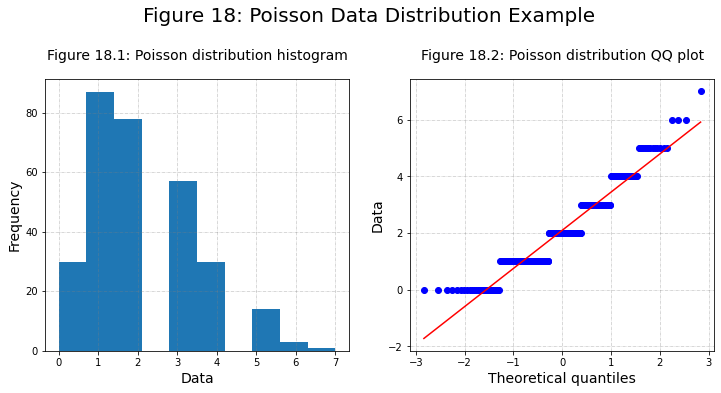

In [53]:
poisson_sample=stats.poisson.rvs(2, size=300)

# Initialize layout
fig18, axs = plt.subplots(figsize = (12, 5), nrows=1, ncols=2)

# Add scatterplot
axs[0].hist(poisson_sample)
stats.probplot(poisson_sample, plot=axs[1])

# Set titles
axs[0].set_title('Figure 18.1: Poisson distribution histogram', fontsize=14, loc='Center', y=1.05)    
axs[1].set_title('Figure 18.2: Poisson distribution QQ plot', fontsize=14, loc='Center', y=1.05)    

# Set axis
axs[0].set_xlabel('Data', fontsize=14)
axs[0].set_ylabel('Frequency', fontsize=14)
axs[1].set_xlabel('Theoretical quantiles', fontsize=14)
axs[1].set_ylabel('Data', fontsize=14)



# Add grid lines
for ax in axs:
    ax.grid(b = True, color ='grey',
            linestyle ='-.', linewidth = 0.5,
            alpha = 0.6)

#Set figure title
plt.suptitle('Figure 18: Poisson Data Distribution Example', fontsize=20, y=1.08)
plt.show()

plt.show()

Notice the aggregation tendency to distinct clusters.

### 3.2.5 Exponential distribution
The Exponential distribution accounts for time or distance across events, in engineering it is commnoly used to model time to faillure. 

Note that a key assumption in any simulation study for either the Poisson or exponential distribution is that the rate, $\lambda$, remains constant over the period being considered. Let's look up an example.

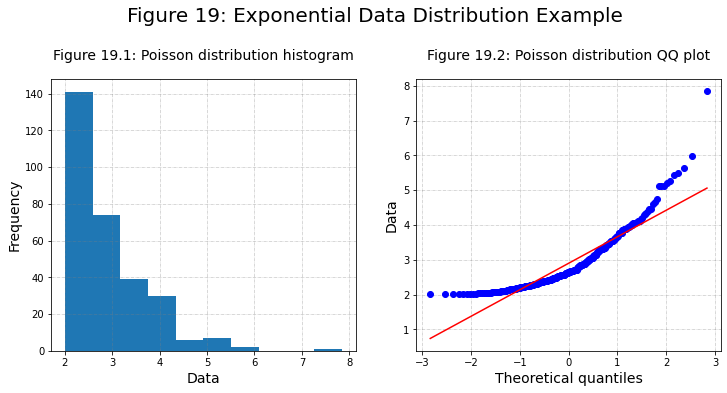

In [54]:
expo_sample=stats.expon.rvs(2, size=300)

# Initialize layout
fig19, axs = plt.subplots(figsize = (12, 5), nrows=1, ncols=2)

# Add scatterplot
axs[0].hist(expo_sample)
stats.probplot(expo_sample, plot=axs[1])

# Set titles
axs[0].set_title('Figure 19.1: Exponential distribution histogram', fontsize=14, loc='Center', y=1.05)    
axs[1].set_title('Figure 19.2: Exponential distribution QQ plot', fontsize=14, loc='Center', y=1.05)    

# Set axis
axs[0].set_xlabel('Data', fontsize=14)
axs[0].set_ylabel('Frequency', fontsize=14)
axs[1].set_xlabel('Theoretical quantiles', fontsize=14)
axs[1].set_ylabel('Data', fontsize=14)



# Add grid lines
for ax in axs:
    ax.grid(b = True, color ='grey',
            linestyle ='-.', linewidth = 0.5,
            alpha = 0.6)

#Set figure title
plt.suptitle('Figure 19: Exponential Data Distribution Example', fontsize=20, y=1.08)
plt.show()

plt.show()

Notice the continuity of the distribution, although it follows the same rate of event.

### 3.2.6 Weibull distribution
A main problem with both the Poissons and Exponential distribution, is the case the where the **event rate** is not constatnt (which is generally the case), an example would be during a mechanical faillure of a component.

The Weibull distribution is an extension of the exponential distribution in which the event rate is allowed to change, as specified by a shape parameter, $\beta$. If $\beta >1$, the probability of an event increases over time; if $\beta < 1$ , the probability decreases. Because the Wei‐
bull distribution is used with time-to-failure analysis instead of event rate, the second parameter is expressed in terms of characteristic life, rather than in terms of the rate of events per interval. The symbol used is $\eta$, the Greek letter $\eta$. It is also called the scale parameter.

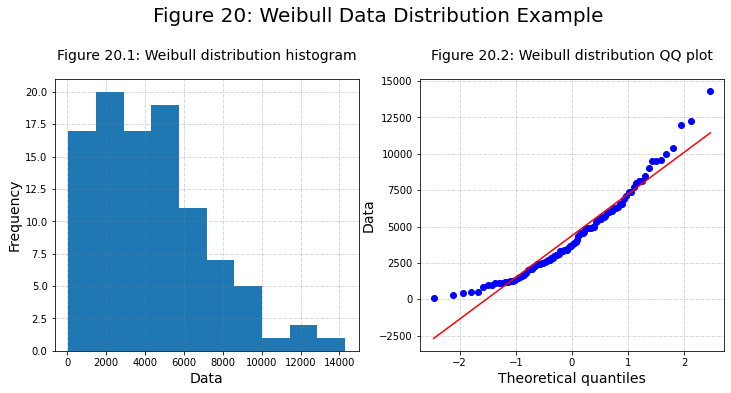

In [56]:
weibull_sample=stats.weibull_min.rvs(1.5, scale=5000, size=100)

# Initialize layout
fig20, axs = plt.subplots(figsize = (12, 5), nrows=1, ncols=2)

# Add scatterplot
axs[0].hist(weibull_sample)
stats.probplot(weibull_sample, plot=axs[1])

# Set titles
axs[0].set_title('Figure 20.1: Weibull distribution histogram', fontsize=14, loc='Center', y=1.05)    
axs[1].set_title('Figure 20.2: Weibull distribution QQ plot', fontsize=14, loc='Center', y=1.05)    

# Set axis
axs[0].set_xlabel('Data', fontsize=14)
axs[0].set_ylabel('Frequency', fontsize=14)
axs[1].set_xlabel('Theoretical quantiles', fontsize=14)
axs[1].set_ylabel('Data', fontsize=14)



# Add grid lines
for ax in axs:
    ax.grid(b = True, color ='grey',
            linestyle ='-.', linewidth = 0.5,
            alpha = 0.6)

#Set figure title
plt.suptitle('Figure 20: Weibull Data Distribution Example', fontsize=20, y=1.08)
plt.show()

plt.show()


The key ideas to keep in mind regarding distributions are the following:
- Most data is not normally distributed.
-  The t-distribution is actually a family of distributions resembling the normal distribution but with thicker tails.
-  Binomial outcomes are important to model, since they represent, among other things, fundamental decisions (True, maybe, false.)
- For events that occur at a constant rate, the number of events per unit of time or space can be modeled as a Poisson distribution.
- You can also model the time or distance between one event and the next as an exponential distribution.
- A changing event rate over time (e.g., an increasing probability of device failure) can be modeled with the Weibull distribution.

___

**Congratulations** on completing this fourth notebook, remember that you do not need to remember each one by heart. You can refer back to this notebook when needed. I know it was quite extensive, but that's usually all you need for a statistically-grounded machine learning project. But don't worry, we will explore deeper concepts in the case studies.

Now that we have a good understanding of insight extraction, let's move on to effective data visualization. The most fun part of the project. We'll explore the different types of graphs, how and where to implement them, and most importantly how to make **good** insightful graphs. So, see you soon ;)